# Importing necessary things

In [36]:
import pandas as pd
import numpy as np
import sklearn

import sklearn.metrics as metrics
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, RegexpTokenizer, TweetTokenizer

import matplotlib.pyplot as plt
import seaborn as sns

import re
from datetime import datetime

import pickle

==================================================================================================================

In [3]:
from pathlib import Path

root = Path('.')

my_path1 = root / "tokens" / "processedreviewrating1.pbz2"
my_path2 = root / "tokens" / "processedreviewrating2.pbz2"
my_path3 = root / "tokens" / "processedreviewrating3.pbz2"
my_path4 = root / "tokens" / "processedreviewrating4.pbz2"
my_path5 = root / "tokens" / "processedreviewrating5.pbz2"

import bz2

def compressed_pickle(path, data):
    with bz2.BZ2File(path, 'w') as f:
        pickle.dump(data, f)

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = pickle.load(data)
    return data

In [4]:
bigreviewlist = decompress_pickle('compressedbiglistreview.pbz2')
dfreview = pd.DataFrame(bigreviewlist)
dfreview.head(2)

,content,score,appId
0,"Great game! First, the bad. There are plenty o...",4,com.innersloth.spacemafia
1,It's a really amazing start for a game but the...,4,com.innersloth.spacemafia


In [5]:
rating1 = decompress_pickle(my_path1)
rating2 = decompress_pickle(my_path2)
rating3 = decompress_pickle(my_path3)
rating4 = decompress_pickle(my_path4)
rating5 = decompress_pickle(my_path5)

### Downsampling 

In [8]:
# Downsample due to unbalanced dataset

starttime = datetime.now()


rating1downsample = resample(rating1,
                            replace=False,
                            n_samples=len(rating2),
                            random_state=72)
rating3downsample = resample(rating3,
                            replace=False,
                            n_samples=len(rating2),
                            random_state=72)
rating4downsample = resample(rating4,
                            replace=False,
                            n_samples=len(rating2),
                            random_state=72)
rating5downsample = resample(rating5,
                            replace=False,
                            n_samples=len(rating2),
                            random_state=72)

print(datetime.now() - starttime)
print('------------')
print(len(rating1downsample))
print(len(rating3downsample))
print(len(rating4downsample))
print(len(rating5downsample))

0:00:02.975819
------------
74308
74308
74308
74308


In [9]:
starttime = datetime.now()

dfreviewdown = pd.concat([rating1downsample, rating2, rating3downsample, rating4downsample, rating5downsample])

print(datetime.now() - starttime)
print('------------')
print(len(dfreviewdown))

0:00:00.358392
------------
371540


In [24]:
# Remove common words
stopwords_list = stopwords.words('english') + list(string.punctuation)
# Remove more punctuation
stopwords_list += ["''", '""', '...', '``']
# Remove random numerals
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# Remove contractions
stopwords_list += ["'d", "'ve", "ca", "n't",  "'t", "'re", "'ll", "'s"]

In [28]:
def process_reviews(reviews):
    tokens = nltk.word_tokenize(reviews)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed  

lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

In [29]:
starttime = datetime.now()

dfreviewdown['wordlist'] = dfreviewdown['content'].apply(lambda x: process_reviews(x))
dfreviewdown['wordlistlem'] = dfreviewdown['wordlist'].apply(lemmatize_text)
dfreviewdown['strings'] = [' '.join(i) for i in dfreviewdown['wordlistlem']]

print(datetime.now() - starttime)
print('------------')
print(dfreviewdown['strings'])

0:02:51.988637
------------
179202    crapy control controld dont work developer gam...
468048    horrible first downloaded app started hanging ...
489520                                      understand game
609033    playing game also member started became member...
967690    unplayable first screen stay bigger size keybo...
                                ...                        
365575                                great variety classic
181636    love game fun addicting play work play everywhere
686756                            good definitely need work
739687    kind disheartened feel like pay play game exci...
561704    level 143 first level stuck day made eventuall...
Name: strings, Length: 371540, dtype: object


### TF-IDF

In [30]:
x = dfreviewdown['strings']
y = dfreviewdown['score']

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 44)

In [31]:
vec = TfidfVectorizer()

tfidf_X_train = vec.fit_transform(X_train)
tfidf_X_test = vec.transform(X_test)

### Dummy Classifier Baseline Model

In [32]:
from sklearn.dummy import DummyClassifier

dclf = DummyClassifier()
dclf.fit(tfidf_X_train, y_train)
y_preds_dummy = dclf.predict(tfidf_X_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [33]:
#Evaluation Metrics for Dummy Classifier

print("Test Accuracy Score:", metrics.accuracy_score(y_test, y_preds_dummy))
print("Test Precision Score:", metrics.precision_score(y_test, y_preds_dummy, average = "weighted"))
print("Test Recall Score:", metrics.recall_score(y_test, y_preds_dummy, average = "weighted"))
print("Test F1 Score:", metrics.f1_score(y_test, y_preds_dummy, average = "weighted"))

Test Accuracy Score: 0.20040910803681972
Test Precision Score: 0.20040042275439818
Test Recall Score: 0.20040910803681972
Test F1 Score: 0.20040254435529709


### Naive Bayes

In [34]:
NB = MultinomialNB(fit_prior = False)

NB.fit(tfidf_X_train,y_train)

y_pred_nb_test = NB.predict(tfidf_X_test)

print("Test Accuracy Score:", metrics.accuracy_score(y_test, y_pred_nb_test))
print("Test Precision Score:", metrics.precision_score(y_test, y_pred_nb_test, average = "weighted"))
print("Test Recall Score:", metrics.recall_score(y_test, y_pred_nb_test, average = "weighted"))
print("Test F1 Score:", metrics.f1_score(y_test, y_pred_nb_test, average = "weighted"))

Test Accuracy Score: 0.45028799052591917
Test Precision Score: 0.4484780206645797
Test Recall Score: 0.45028799052591917
Test F1 Score: 0.4482985710475769


Text(91.68, 0.5, 'Predicted Rating')

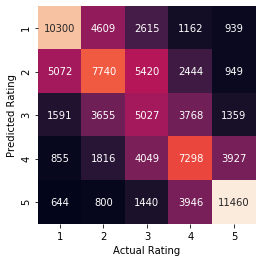

In [37]:
matrix = confusion_matrix(y_test, y_pred_nb_test)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['1','2','3','4','5'], yticklabels=['1','2','3','4','5'])

plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

### Decision Tree

In [38]:
# This takes 9 minutes to run

starttime = datetime.now()

dtc = DecisionTreeClassifier(class_weight='balanced', random_state=22)

dtc.fit(tfidf_X_train, y_train)

y_pred_dtc_test = dtc.predict(tfidf_X_test)

print(datetime.now() - starttime)
print('------------')
print("Test Accuracy Score:", metrics.accuracy_score(y_test, y_pred_dtc_test))
print("Test Precision Score:", metrics.precision_score(y_test, y_pred_dtc_test, average = "weighted"))
print("Test Recall Score:", metrics.recall_score(y_test, y_pred_dtc_test, average = "weighted"))
print("Test F1 Score:", metrics.f1_score(y_test, y_pred_dtc_test, average = "weighted"))

0:08:54.515107
------------
Test Accuracy Score: 0.3539753458577811
Test Precision Score: 0.34881605298273455
Test Recall Score: 0.3539753458577811
Test F1 Score: 0.3509330883474596


Text(91.68, 0.5, 'Predicted Rating')

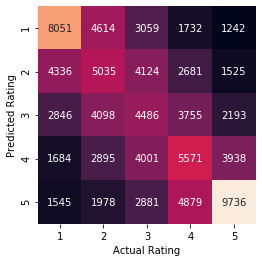

In [39]:
matrix = confusion_matrix(y_test, y_pred_dtc_test)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['1','2','3','4','5'], yticklabels=['1','2','3','4','5'])

plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

### Random Forest

In [40]:
# Takes 1 hour 30 min with 200 n_estimators, half the time with 100. Similar results.

starttime = datetime.now()

rfc = RandomForestClassifier(n_estimators = 100, criterion='entropy', random_state = 11, n_jobs=-1)

rfc.fit(tfidf_X_train, y_train)

y_pred_rfc_test = rfc.predict(tfidf_X_test)

print(datetime.now() - starttime)
print('------------')
print("Test Accuracy Score:", metrics.accuracy_score(y_test, y_pred_rfc_test))
print("Test Precision Score:", metrics.precision_score(y_test, y_pred_rfc_test, average = "weighted"))
print("Test Recall Score:", metrics.recall_score(y_test, y_pred_rfc_test, average = "weighted"))
print("Test F1 Score:", metrics.f1_score(y_test, y_pred_rfc_test, average = "weighted"))

0:44:58.806163
------------
Test Accuracy Score: 0.4447219680249771
Test Precision Score: 0.42740208815620706
Test Recall Score: 0.4447219680249771
Test F1 Score: 0.43046895546013314


Text(91.68, 0.5, 'Predicted Rating')

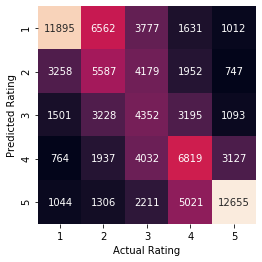

In [41]:
matrix = confusion_matrix(y_test, y_pred_rfc_test)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['1','2','3','4','5'], yticklabels=['1','2','3','4','5'])

plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')